<a href="https://colab.research.google.com/github/xiaoras/Discretizing-the-Spacetime/blob/master/discretizing_the_spacetime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on:

- [F Dowker, J Henson and R D Sorkin, Mod. Phys. Lett. A19 (2004)](https://www.worldscientific.com/doi/abs/10.1142/S0217732304015026)

- [R R Coifman and S Lafon. Applied and Computational Harmonic Analysis 21 (2006)](https://www.sciencedirect.com/science/article/pii/S1063520306000546)

- [S Varadhan, Comm. Pure Appl. Math. 20 (1967)](https://onlinelibrary.wiley.com/doi/abs/10.1002/cpa.3160200404)

# 1. A Discretization Procedure that Preserves the Symmetries of the Continuum

Question: can we discretize a continuous space (think about the spacetime) without breaking its symmetries?

For simplicity, consider 2-dimensional flat case:

- Euclidean space: symmetries are 2-translations and rotations

- Minkowski space: symmetries are 2-translations and boosts

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
class Vertex():

  def __init__(self, coords):
    self.coords = coords # a numpy array with x0, x1, .., xD coordinates of the vertex

  def dist2(self, v, s): # square distance (s=+1 Euclidean, s=-1 Lorentzian) between the vertex and another vertex v
    diff = self.coords - v.coords
    return s * diff[0]**2 + diff[1:] @ diff[1:]

In [ ]:
class Cell2d():

  def __init__(self, coords, l):
    self.coords = coords # coordinates of the bottom-left corener of the cell
    self.l = l # length of a side of the cell

  def contains(self, v):
  # returns True if the cell contains vertex v
    diff = v.coords - self.coords 
    if (0 <= diff[0] < self.l and 0 <= diff[1] < self.l):
      return True
    return False

In [ ]:
class Space2d():

  def __init__(self, size, l, bulk):
    self.size = size # length of a side of space (in Planck units)
    self.l = l # size of a single cell (in Planck units)
    self.bulk = bulk # percentage of the space's size consisting of the bulk
    self.M = int(size/l) # number of cells on a side

    self.cells = [] # list of cells (filled by cell_construct())
    self.cells_b = [] # list of bulk cells (filled by cell_construct())
    self.cell_construct() # fills cells and cells_bulk

    self.verts = [] # list of vertices (filled using a 'sprinkle' method)
    self.verts_b = [] # list of bulk vertices (filled using a 'sprinkle' method)

    self.wghts = np.array([[]]) # nxn matrix (where n is number of vertices): weight of edge between any two vertices
    self.epsilon = 0 # epsilon-parameter of heat kernel

  # CONSTRUCTION: CELLS

  def cell_construct(self):
  # construct self.cells and self.cells_b
    S = np.linspace(-self.size/2, self.size/2 - 1, self.M)
    mesh0, mesh1 = np.meshgrid(S, S)
    # mesh0 is a MxM matrix: mesh0[m0, m1] is the coordinate x_0 of cell (m_0, m_1); same for mesh1
    for m0 in range(self.M):
      for m1 in range(self.M):
        x0 = mesh0[m0, m1]
        x1 = mesh1[m0, m1]
        cell = Cell2d(np.array([x0, x1]), self.l)
        self.cells.append(cell)
        # bulk cells
        if self.in_bulk(cell):
          self.cells_b.append(cell)

  # CONSTRUCTION: VERTICES

  def sprinkle_reg(self):
  # construct self.verts (and self.verts_b) with a regular lattice, one vertex per cell
    self.verts, self.verts_b = [], []
    for cell in self.cells:
      vert = Vertex(cell.coords + self.l/2)
      self.verts.append(vert)
      # bulk verts
      if self.in_bulk(vert):
        self.verts_b.append(vert)

  def sprinkle_ran(self, seed=None):
  # construct self.verts (and self.verts_b) from a uniform random distribution (with number of vertices = number of cells)
    np.random.seed(seed)
    self.verts, self.verts_b = [], []
    for i in range(len(self.cells)):
      vert = Vertex(np.random.uniform(-self.size/2, self.size/2, 2))
      self.verts.append(vert)
      # bulk verts
      if self.in_bulk(vert):
        self.verts_b.append(vert)

  # CONSTRUCTION: GRAPH

  def graph_heat_kernel(self, epsilon, s):
  # fix self.epsilon and construct the weight matrix, self.wghts, of edges between vertices (based on heat Kernel)
    W = [[self.heat_kernel(v1, v2, epsilon, s) for v2 in self.verts] for v1 in self.verts]
    self.wghts = np.array(W)
    self.epsilon = epsilon

  def graph_near_neighs(self, N_neighbors, s):
  # construct the weight matrix, self.wghts, of edges between vertices (based on heat N_neighbors nearest neighbors)
  # note: this does not mean that every vertex in graph is N_neighbors-valent, but that every vertex is *at least* N_neighbors-valent
    neighs = {v : self.nearest_neighbours(v, N_neighbors, s) for v in self.verts}
    W = [[1 if (v2 in neighs[v1] or v1 in neighs[v2]) else 0 for v2 in self.verts] for v1 in self.verts]
    self.wghts = np.array(W)
  
  def graph_tassellation(self, s):
  # construct the weight matrix, self.wghts, of edges between vertices: two vertices are connected if there is no vertex "between" them
  # note: involves 3 nested cycles over all vertices, hence it gets slow easily
    W = []
    for v1 in self.verts:
      W_row = []
      for v2 in self.verts:
        d12 = v1.dist2(v2, s)
        if any([(w.dist2(v1, s) < d12 and w.dist2(v2, s) < d12) for w in self.verts]):
          W_row.append(0)
        else:
          W_row.append(1)
      W.append(W_row)
    self.wghts = np.array(W)

  # TRANSFORMATIONS

  def rotat(self, t):
  # rotate all vertices by angle t
    R = np.array([[np.cos(t), -np.sin(t)],[np.sin(t), np.cos(t)]])
    new_verts, new_verts_b = [], []
    for vert in self.verts:
      new_vert = Vertex(R @ vert.coords)
      new_verts.append(new_vert)
      if self.in_bulk(new_vert):
        new_verts_b.append(new_vert)
    self.verts = new_verts
    self.verts_b = new_verts_b

  def boost(self, v):
  # boost all vertices by velocity v (in Planck units)
    Lambda = 1/np.sqrt(1 - v**2) * np.array([[1, -v],[-v, 1]])
    new_verts, new_verts_b = [], []
    for vert in self.verts:
      new_vert = Vertex(Lambda @ vert.coords)
      new_verts.append(new_vert)
      if self.in_bulk(new_vert):
        new_verts_b.append(new_vert)
    self.verts = new_verts
    self.verts_b = new_verts_b

  # GEOMETRIC OBJECTS [require self.wghts via self.graph_heat_kernel method]

  def laplacian(self, bulk_only=False):
  # return the graph Laplacian L from the heat-kernel weights in self.wghts
  # note: L is a N x N matrix (with N number of vertices): if f is a function on space,
  # we discretize it on the graph as a N-vector f = (f_1,..,f_N) with f_i := f(v_i);
  # then g := L f is a N-vector corresponding to the discretization of function nabla^2 f.
  # if bulk_only=True, return a reduced matrix involving only v in self.verts_b
    K, N = self.wghts, len(self.verts)
    e = np.ones(N)
    q = np.diag(K @ e)
    q_inv = np.linalg.inv(q)
    K_prime = q_inv @ K @ q_inv
    d = np.diag(K_prime @ e)
    d_inv = np.linalg.inv(d)
    D = d_inv @ K_prime
    L = (D - np.identity(N))/self.epsilon
    if bulk_only: # remove from L the rows/columns that correspond to vertices outside the bulk
      bound_verts_idxs = []
      for v, i in zip(self.verts, range(len(self.verts))):
        if v not in self.verts_b:
          bound_verts_idxs.append(i)
      L = np.delete(L, bound_verts_idxs, axis=0)
      L = np.delete(L, bound_verts_idxs, axis=1)
    return L

  def g_inv(self, bulk_only=False):
  # return a n-vector: the ith entry is the (discretized) inverse metric at vertex v_i
  # if bulk_only=True, return a reduced matrix involving only v in self.verts_b
    L = self.laplacian(bulk_only)
    if bulk_only:
      V = self.verts_b
    else:
      V = self.verts
    D = range(2) # dimension of spacetime
    N = range(len(V)) # number of vertices
    x = np.array([[v.coords[mu] for mu in D] for v in V]) # NxD matrix: x[i, mu] (i.e., the mu-coordinate of vertex v_i)
    xx = np.array([np.tensordot(x[i,:], x[i,:], axes=0) for i in N]) # NxDxD matrix: xx[i, mu, nu] = x[i, mu] * x[i, nu]
    Lxx = np.tensordot(L, xx, axes=(1, 0)) # NxDxD matrix: Lxx[i, mu, nu] = sum(L[i, j] * xx[j, mu, nu], j)
    xLx1 = np.array([np.tensordot(x[i,:], (L @ x)[i,:], axes=0) for i in N]) # NxDxD matrix: xLx1[i, mu, nu] = x[i, mu] * (L @ x)[i, nu]
    xLx2 = np.array([np.tensordot((L @ x)[i,:], x[i,:], axes=0) for i in N]) # NxDxD matrix: xLx2[i, mu, nu] = (L @ x)[i, mu] * x[i, nu]
    return (Lxx - xLx1 - xLx2)/2

  def g(self, bulk_only=False):
  # return a n-vector: the ith entry is the (discretized) metric at vertex v_i
  # if bulk_only=True, return a reduced matrix involving only v in self.verts_b
    g_inv = self.g_inv(bulk_only)
    metric = [np.linalg.inv(matrix) for matrix in g_inv]
    return np.array(metric)

  # VISUALIZATION

  def plot(self, ax, cells=False, graph=False, bound=None, color='k'):
  # draws in ax the plot of vertices in self.verts
  # bound in (0,1): percentage of the whole space which is plotted
  # cells=True: show the grid of cells
  # graph=r (for r a positive real): draw the edges with weight > r
    bound = bound if bound else self.bulk
    V0, V1 = [], []
    for v in self.verts:
      V0.append(v.coords[0])
      V1.append(v.coords[1])
    ax.scatter(V0, V1, color=color, marker='.')
    if cells:
      S = np.linspace(-self.size/2, self.size/2 - 1, self.M)
      for s in S:
        ax.axvline(x = s, color='k', alpha=0.25)
        ax.axhline(y = s, color='k', alpha=0.25)
    if graph:
      G = self.get_graph(thresh=graph)
      pos = [v.coords for v in self.verts]
      nx.draw_networkx(G, pos, arrows=False, with_labels=False, ax=ax, node_size=50, node_color=color)
    ax.tick_params(reset=True)
    ax.set_xlim(-bound*self.size/2,bound*self.size/2)
    ax.set_ylim(-bound*self.size/2,bound*self.size/2)

  # UTILITIES

  def in_bulk(self, obj):
  # return True if obj.coords are within the bulk
    bs = self.bulk * self.size/2
    if (-bs <= obj.coords[0] < bs and -bs <= obj.coords[1] < bs):
      return True
    return False

  def heat_kernel(self, v1, v2, epsilon, s):
  # heat kernel based on square distance between 2 points (vertices) v1 and v2
  # note: in Minkowski case (s=-1), the exponent is not necessarily positive [THIS IS A PROBLEM!]
    Delta2 = v1.dist2(v2, s)
    # return np.exp(-Delta2/(epsilon))
    return np.exp(-Delta2/(4 * epsilon))

  def nearest_neighbours(self, v, N_neighbors, s):
  # return a list of N_neighbors vertices: the nearest neighbors of v (excluding v itself)
    dist_from_v = {}
    for w in self.verts:
      d2 = v.dist2(w, s) # compute distance of w from v
      dist_from_v[w] = d2 # store it in the dictionary dist_from_v
    v_neighbors = sorted(self.verts, key=lambda w: dist_from_v[w]) # create a new list from self.verts by ordering it wrt dist_from_v
    v_neighbors = v_neighbors[1:N_neighbors+1] # restrict to N_neighbors elements (the nearest neighbors)
    return v_neighbors

  def get_graph(self, thresh):
  # return a networkx.Graph object obtained from self.wghts by retaining only the edges with weight > thresh
    R = range(len(self.verts))
    W = [[1 if self.wghts[i, j] > thresh else 0 for i in R] for j in R]
    W = np.array(W)
    return nx.from_numpy_matrix(W)

The fist option is to use a regular discretization. We separate the space in cells (of size, say, $\ell_{\rm Planck}$), and then put a vertex in each cell:

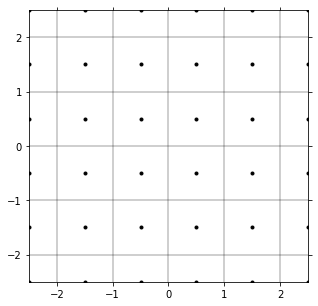

In [ ]:
M = Space2d(10, 1, bulk=0.2)
M.sprinkle_reg()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
M.plot(ax=ax, cells=True, bound=0.5)

Now, depending on the signature of the space, we are interested in performing rotations or boosts.

In [ ]:
import ipywidgets as widgets

M1 = Space2d(20, 1, bulk=0.5)
M1.sprinkle_reg()

M2 = Space2d(20, 1, bulk=0.5)
M2.sprinkle_reg()

def update(t):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  M1.rotat(t*np.pi)
  M1.plot(ax=ax, cells=False, graph=False, color='k')
  M1.rotat(-t*np.pi)

widgets.interact(update, t=(-0.25, 0.25, 0.01));

def update(v):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  M2.boost(v)
  M2.plot(ax=ax, cells=False, graph=False, color='k')
  M2.boost(-v)

widgets.interact(update, v=(-0.25, 0.25, 0.01));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.25, min=-0.25, step=0.01), Output()), _dom…

interactive(children=(FloatSlider(value=0.0, description='v', max=0.25, min=-0.25, step=0.01), Output()), _dom…

Let us see the extreme cases:

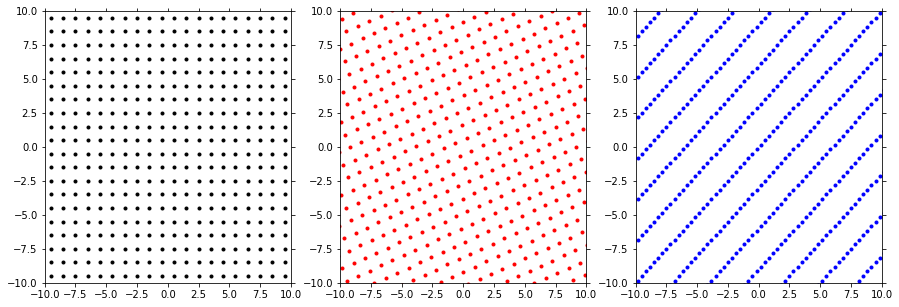

In [ ]:
Mreg1 = Space2d(100, 1, bulk=0.2)
Mreg2 = Space2d(100, 1, bulk=0.2)
Mreg3 = Space2d(100, 1, bulk=0.2)

Mreg1.sprinkle_reg()
Mreg2.sprinkle_reg()
Mreg3.sprinkle_reg()

Mreg2.rotat(np.pi/8)
Mreg3.boost(0.8)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
Mreg1.plot(ax=axes[0], cells=False, graph=False, color='k')
Mreg2.plot(ax=axes[1], cells=False, graph=False, color='r')
Mreg3.plot(ax=axes[2], cells=False, graph=False, color='b')

As we knew already, the regular discretization is clearly **not** invariant under the symmetries of flat space:

$$
\text{symmetry}: \ \ \text{regular discretization} \ \ \longrightarrow \ \ \text{not regular discretization}
$$

 The reason why this is bad is that, by looking at one of these pictures, **we are able to tell** whether it has been transformed or not. Hence, we have singled out a special frame (the one wrt which the picture appears not transformed, i.e., regular).

Consider now the following 3 pictures:

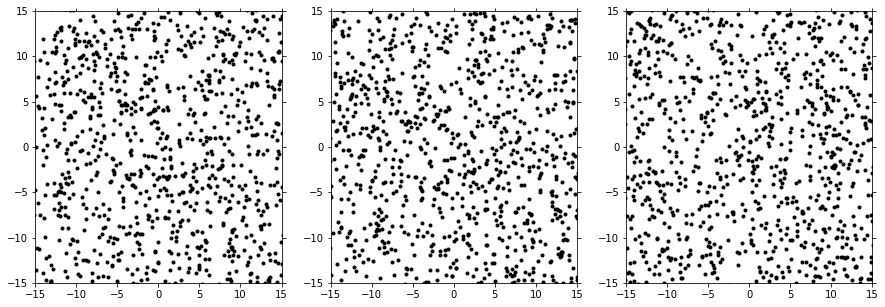

In [ ]:
Mran1 = Space2d(100, 1, bulk=0.3)
Mran2 = Space2d(100, 1, bulk=0.3)
Mran3 = Space2d(100, 1, bulk=0.3)

Mran1.sprinkle_ran(seed=1)
Mran2.sprinkle_ran(seed=1)
Mran3.sprinkle_ran(seed=1)

Mran2.rotat(np.pi/8)
Mran3.boost(0.8)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
Mran1.plot(ax=axes[0], cells=False, graph=False)
Mran2.plot(ax=axes[1], cells=False, graph=False)
Mran3.plot(ax=axes[2], cells=False, graph=False)

One of them is the "real one", the other two have been transformed (using the same parameters as in the regular case). Can you tell which is the real one?

The original figure is obtained by choosing points according to the Poisson distribution: the probability that $k$ points will be in a cell (of size $\ell_{\rm Planck}$) is given by

$$
p(k) = \dfrac{\mu^k e^{-\mu}}{k!}
$$

with $\mu = 1$. The discretization we obtain is **not** invariant under the symmetries of the continuum manifold (the three figures above are different from each other), but we cannot use this fact to single out a special frame. This is because

$$
\text{symmetry}: \ \ \text{Poisson discretization} \ \ \longrightarrow \ \ \text{(another) Poisson discretization}
$$

In [ ]:
M3 = Space2d(75, 1, bulk=0.25)
M3.sprinkle_ran(seed=1)

def update(v):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  M3.boost(v)
  M3.plot(ax=ax, cells=False, graph=False, color='k')
  M3.boost(-v)

widgets.interact(update, v=(-0.9, 0.9, 0.01));

interactive(children=(FloatSlider(value=0.0, description='v', max=0.9, min=-0.9, step=0.01), Output()), _dom_c…

We can check that all of three discretizations above follow the Poisson distribution:

In [ ]:
def vertex_count(M):
# Given a Space2d object, count how many vertices are in each cell.
# Return an array: the ith element is the number of (bulk) vertices in ith cell.
  C = [] 
  for cell in M.cells_b:
    count = 0
    for vert in M.verts_b:
      if cell.contains(vert):
        count = count + 1
    C.append(count)
  return np.array(C)

C1 = vertex_count(Mran1)
mean1 = np.around(C1.mean(), 2)
std1 = np.around(C1.std(), 2)

print("\noriginal discretization:")
print("average number of vertices per cell = {0}".format(mean1))
print("standard deviation = {0}".format(std1))

C2 = vertex_count(Mran2)
mean2 = np.around(C2.mean(), 2)
std2 = np.around(C2.std(), 2)

print("\nrotated by t = pi/8:")
print("average number of vertices per cell = {0}".format(mean2))
print("standard deviation = {0}".format(std2))

C3 = vertex_count(Mran3)
mean3 = np.around(C3.mean(), 2)
std3 = np.around(C3.std(), 2)

print("\nboosted by v = 0.8:")
print("average number of vertices per cell = {0}".format(mean3))
print("standard deviation = {0}".format(std3))


original discretization:
average number of vertices per cell = 0.98
standard deviation = 1.01

rotated by t = pi/8:
average number of vertices per cell = 1.0
standard deviation = 1.0

boosted by v = 0.8:
average number of vertices per cell = 1.0
standard deviation = 1.01


Recall that, for Poisson distribution, $\mathbb E[K] = \mu$ and $\text{Var}[K] = \mu$.

More explicitely, we can count the number $n(k)$ of cells that contain $k$ vertices, and make a histogram $n(k)$ against $k$. The theoretical value predicted by Poisson distribution is

$$
n_{\rm theo}(k) = N p(k)
$$

where $N$ is the total number of cells.

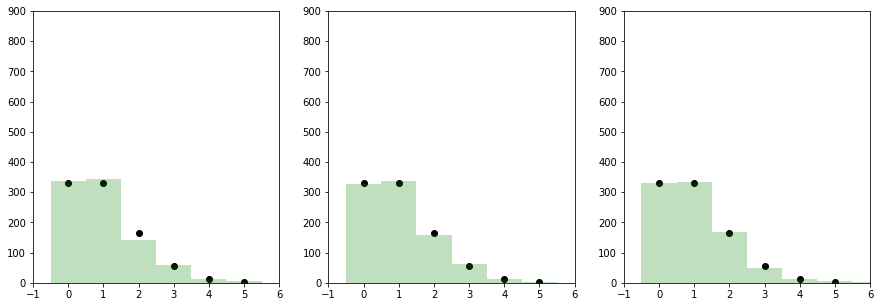

In [ ]:
from scipy.stats import poisson

def plot_histogram(C, ax):
  ns = range(0, 6)
  n_theo = len(C) * poisson.pmf(ns, mu=1)
  bins = np.arange(min(C), max(C) + 2) - 0.5
  ax.scatter(ns, n_theo, color='k')
  ax.hist(C, bins=bins, alpha=0.25, color='g')
  ax.set_xlim([-1, 6])
  ax.set_ylim([0, len(C)])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot_histogram(C1, ax=axes[0])
plot_histogram(C2, ax=axes[1])
plot_histogram(C3, ax=axes[2])

For comparison, let us look at the regularly-discretized space:

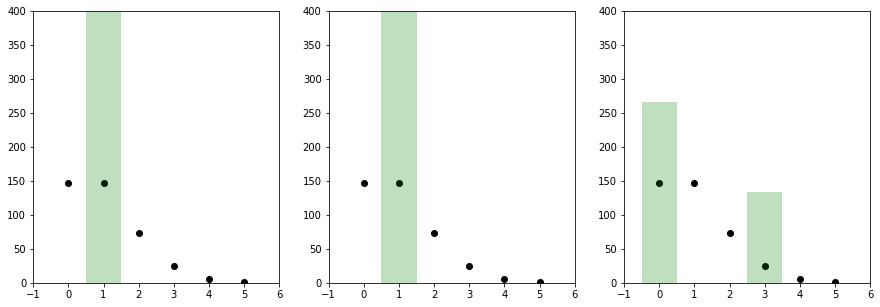

In [ ]:
C1 = vertex_count(Mreg1)
C2 = vertex_count(Mreg2)
C3 = vertex_count(Mreg3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot_histogram(C1, ax=axes[0])
plot_histogram(C2, ax=axes[1])
plot_histogram(C3, ax=axes[2])

# 2. Graph associated to a Discretization

Given a discretization, we can represent an associated graph via an **adjacency matrix** $W$: if $i = 1, 2, .., N_V$ ranges over all vertices, $W$ is a $N_V \times N_V$ matrix with

$$
W_{ij} = \left\{
\begin{array}{ll}
1 & \text{if there exists an edge between} \ v_i \ \text{and} \ v_j
\\
0 & \text{otherwise}
\end{array}
\right.
$$

Furthermore, if edges carry a "color" (e.g., positive integers), we can use the same idea: $W_{ij}$ represents the color of the edge between vertices $v_i$ and $v_j$.

There are several ways to associate a graph with a discretization. For example, we can construct the **k-nearest neighbor graph**: $W_{ij} = 1$ if $v_i$ is among the $k$ nearest neighbours of $v_j$ or if $v_j$ is among the $k$ nearest neighbours of $v_i$ (note that this property is not symmetric).

Examples in flat Euclidean case ($k = 4$):

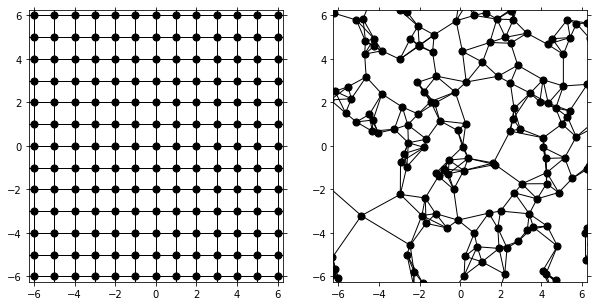

In [ ]:
Mreg = Space2d(25, 1, bulk=0.5)
Mran = Space2d(25, 1, bulk=0.5)

Mreg.sprinkle_reg()
Mran.sprinkle_ran(seed=1)

Mreg.graph_near_neighs(N_neighbors=4, s=1)
Mran.graph_near_neighs(N_neighbors=4, s=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
Mreg.plot(ax=axes[0], graph=0.5)
Mran.plot(ax=axes[1], graph=0.5)

Note that, for this to work, we need to be able to associate a **distance** between points. If we are in Riemannian geometry, the obvious choice is to use the square **geodetic distance** $\sigma^2(v_i, v_j)$. While the geodetic distance is defined also in the Lorentzian case, it is not necessarily positive, so it is not clear how to define the concept of "nearest neighbor".

In the following, we will be focusing on a different way to construct the graph, which is useful in light of retaining information about the underlying geometry (see later): we will use the **heat Kernel**.

The idea is simple: given the set of all vertices, build $W$ as

$$
W_{ij} = K_{\epsilon}(v_i, v_j)
$$

where $K_\epsilon(x, y)$ is the heat kernel, i.e., the object such that

$$
u_\epsilon(x) := \int dy \ \sqrt{\det g(y)} \ K_\epsilon(x, y) f(y)
$$

solves the heat equation

$$
\dfrac{d}{d\epsilon} u_\epsilon(x) = \nabla^2 u_\epsilon(x), \ \ \ \ \ u_0(x) = f(x)
$$

with 

$$
\nabla^2f := \dfrac{1}{\sqrt{\det g}} \partial_\mu \big(\sqrt{\det g} \ g^{\mu\nu} \partial_\mu f\big)
$$

In the case of flat Euclidean space, the heat kernel has analytical form:

$$
K_{\epsilon}(x, y) = \exp\left(-\frac{\|x - y\|^2}{4\epsilon}\right)
$$

### Details on Heat Kernel

More generally, one can show that $\nabla^2$ admits eigenvalue decomposition:

$$
\nabla^2 \phi_k(x) = -\lambda_k \phi_k(x)
$$

with $0 \leq \lambda_1 \leq \lambda_2 \leq ...$ and $\lim_{k \to \infty} \lambda_k = \infty$ (in the Riemannian case). Given a function $f$, we can then find the solution to the heat kernel equation as follows: first, expand $f$ on basis $\{\phi_k\}$,

$$
f(x) = \sum_{k} a_k \phi_k(x), \ \ \ \ \ \text{where} \ \ a_k := \int dy \ \sqrt{\det g(y)} \ f(y) \overline{\phi_k(y)}
$$

Then, we see that $e^{\epsilon \nabla^2} f(x) = \sum_{k} a_k e^{-\epsilon \lambda_k} \phi_k(x)$; deriving wrt $s$, we obtain

$$
\dfrac{d}{d\epsilon} e^{\epsilon \nabla^2} f(x) = \sum_{k} a_k e^{-\epsilon \lambda_k} (- \lambda_k) \phi_k(x) = \sum_{k} a_k e^{-\epsilon \lambda_k} \nabla^2 \phi_k(x) = \nabla^2 e^{\epsilon \nabla^2} f(x)
$$

From here, we conclude that the solution to the heat kernel equation is $u_s(x) = e^{s \nabla^2} f(x)$. Writing this explicitely, we find

$$
u_\epsilon(x) = \sum_{k} a_k e^{-\epsilon \lambda_k} \phi_k(x) = \int dy \ \sqrt{\det g(y)} \left[\sum_{k} e^{-\epsilon \lambda_k} \phi_k(x) \overline{\phi_k(y)}\right] f(y)
$$

from which we finally read off the heat kernel:

$$
K_\epsilon(x, y) = \sum_{k} e^{-\epsilon \lambda_k} \phi_k(x) \overline{\phi_k(y)}
$$

Note: as shown by S. Varadhan, the heat Kernel is related to the geodesic distance $\sigma^2$ via the equation

$$
\sigma^2(x, y) = -\lim_{\epsilon \to 0} 4\epsilon \ln(K_s(x, y))
$$

## 2.1 Euclidean Example

In the following, we show the graphs obtained from the heat kernel (with $\epsilon = 0.5$) for the two discretizations (regular and Poisson). Note that we only drow the edges for which $W_{ij} \geq 0.5$ for simplicity.

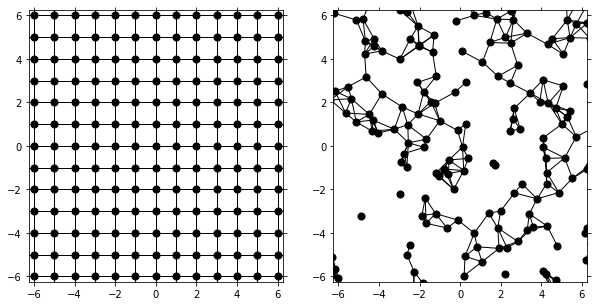

In [ ]:
Mreg = Space2d(25, 1, bulk=0.5)
Mran = Space2d(25, 1, bulk=0.5)

Mreg.sprinkle_reg()
Mran.sprinkle_ran(seed=1)

Mreg.graph_heat_kernel(epsilon=0.5, s=1)
Mran.graph_heat_kernel(epsilon=0.5, s=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
Mreg.plot(ax=axes[0], graph=0.5)
Mran.plot(ax=axes[1], graph=0.5)

Note that the poisson discretization presents a disconnected graph. Is this a problem? Recall however that the graph is not really disconnected: we are just hiding the edges corresponding to points that are further apart. If we show all edges with $W_{ij} \geq 0.25$, we get a much more connected graph:

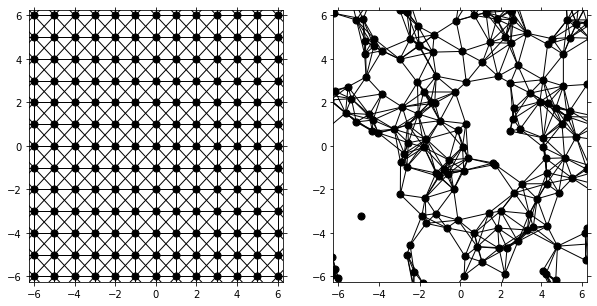

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
Mreg.plot(ax=axes[0], graph=0.25)
Mran.plot(ax=axes[1], graph=0.25)

# 3. Encoding the Metric in the Graph

The continuous manifold is completely characterized by the metric, $g_{\mu\nu}$. How much of this information can we retain at the discrete level?

Let us start by an observation: the inverse metric at point $x_o$, $g^{\mu\nu}(x_o)$, can be recovered from the Laplacian $\nabla^2$ by acting with it on the function

$$
f_{x_o}^{\mu\nu}(x) := \dfrac{1}{2} \big(x^\mu - x^\mu_o\big) \big(x^\nu - x^\nu_o\big)
$$

and evaluating the result at $x = x_o$. Indeed, we have

\begin{align}
(\nabla^2 f_{x_o}^{\mu\nu})(x_o) & = \bigg[\dfrac{1}{\sqrt{\det g(x)}} \partial_\rho \big(\sqrt{\det g(x)} \ g^{\rho\sigma}(x) (\partial_\sigma f_{x_o}^{\mu\nu})(x)\big)\bigg]\bigg|_{x = x_o} =
\\
& = \bigg[\dfrac{1}{\sqrt{\det g(x)}} \partial_\rho \big(\sqrt{\det g(x)} \ g^{\rho\sigma}(x) \frac{\delta^\mu_\sigma (x^\nu - x^\nu_o) + (x^\mu - x^\mu_o) \delta^\nu_\sigma}{2}\big)\bigg]\bigg|_{x = x_o} = 
\\
& = \bigg[g^{\rho\sigma}(x) \delta^{(\mu}_\sigma \delta^{\nu)}_\rho\bigg]\bigg|_{x = x_o} = g^{\mu\nu}(x_o)
\end{align}

Note that the function $f_{x_o}^{\mu\nu}$ is really $16$ different functions built from the coordinates $\{x^\mu\}$, and so they are coordinate-dependent objects. This should not be concerning, though, since $g_{\mu\nu}(x_o)$ is also a coordinate-dependent object: it is the $(\mu,\nu)$-element of the metric **wrt coordinate system** $\{x^\mu\}$:

$$
g_{\mu\nu}(x_o) := g_{x_o}\big(\frac{\partial}{\partial x^\mu}, \frac{\partial}{\partial x^\nu}\big)
$$

Having this result, we now know that a possible way to encode the geometry in the discretization is by discretizing the object $\nabla^2 f_{x_o}^{\mu\nu}$. In particular, if our discretization consists of vertices $\{v_1, .., v_N\}$, we expect to find

\begin{align}
\begin{array}{c}
\text{function} \ f \ \ \longrightarrow \ \ \text{$N$-vector} \ \tilde f_i := f(v_i)
\\
\text{operator} \ \nabla^2 \ \ \longrightarrow \ \ N \times N \ \text{matrix} \ (\tilde \nabla^2)_{ij}
\end{array}
\end{align}

## 3.1 Discretization of the Laplacian

We start from the discretization of $\nabla^2$, in which we follow R. R. Coifman and S. Lafon.

Start from heat kernel $K_\epsilon(x, y)$ and form the new kernel

$$
K_\epsilon'(x, y) := \frac{K_s(x, y)}{q_\epsilon(x) q_\epsilon(y)}
$$

where

$$
q_\epsilon(x) := \int dy \sqrt{\det g(y)} \ K_\epsilon(x, y)
$$

Define the diffusion-like operator $D_{\epsilon}$ via its action on a function $f$:

$$
(D_{\epsilon} f)(x) = \dfrac{1}{d_\epsilon(x)} \int dy \sqrt{\det g(y)} \ K_\epsilon'(x, y) f(y)
$$

where the normalization is given by

$$
d_{\epsilon}(x) := \int dy \sqrt{\det g(y)} \ K_\epsilon'(x, y)
$$

Now, it can be shown that operator

$$
L_{\epsilon} := \frac{D_{\epsilon} - I}{\epsilon}
$$

satisfies

$$
(L_{\epsilon} f)(x) = \nabla^2 f(x) + \mathcal O(\epsilon)
$$

Our proposal is thus to discretize $L_\epsilon$. The procedure is simple: given a set of points (vertices) $\{v_1, .., v_N\}$, we define the discrete operator (i.e., $N \times N$ matrix) $\tilde L_\epsilon$ as

$$
\tilde L_{\epsilon} := \frac{\tilde D_{\epsilon} - \tilde I}{\epsilon}
$$

where $\tilde I$ is the $N \times N$ identity matrix and $\tilde D_\epsilon$
is defined via action on a discrete function (i.e., $N$-vector) $f_i := f(v_i)$:

$$
(\tilde D_{\epsilon} f)_i = \dfrac{1}{(\tilde d_\epsilon)_i} \sum_j (\tilde K_\epsilon')_{ij} f_j, \ \ \ \ \ \text{with} \ \ (\tilde d_\epsilon)_i = \sum_j (\tilde K_\epsilon')_{ij}
$$

where

$$
(\tilde K_\epsilon')_{ij} = \frac{(\tilde K_\epsilon)_{ij}}{(\tilde q_\epsilon)_i (\tilde q_\epsilon)_j}, \ \ \ \ \ \text{with} \ \ (\tilde q_\epsilon)_i = \sum_j (\tilde K_\epsilon)_{ij}
$$

and

$$
(\tilde K_\epsilon)_{ij} := K_\epsilon(v_i, v_j)
$$

Now, it can be shown that the discretized operator $\tilde L_\epsilon$ converges to the continuous one $L_\epsilon$:

$$
(\tilde L_\epsilon f)(v) = (L_\epsilon f)(v) + \mathcal O(\epsilon^{-1/2-d/4}/\sqrt N)
$$

where $d$ is the dimension of the space and $N$ the number of vertices in the discretization. Putting all together (and setting $d=2$, as that is the case in our examples), we get

$$
(\tilde L_\epsilon f)(v) = \nabla^2 f(x) + \mathcal O(\epsilon) + \mathcal O(\frac{1}{\sqrt N \epsilon})
$$

Note that the two errors compete with each other when it comes to $\epsilon$: on the one hand we would like $\epsilon \ll 1$, on the other we need $\sqrt N \epsilon \gg 1$. This can in principle be achieved by increasing $N$, but in reality this soon becomes a problem (since the computational time grows very fast with the number of nodes in the discretization). Luckily, the $\mathcal O(\epsilon)$ error in the approximation $L_{\epsilon} \approx \nabla^2$ is not so bad: it turns out we can safely take $\epsilon = 0.5$ and $N = 625$ (i.e., $25$ cells on each side), which are the parameters that we used above.

We therefore see that, given the heat kernel between any two vertices, $K_\epsilon(v_i, v_j)$, after some linear algebra, we finally obtain the discrete version of the Laplacian operator:

$$
(\nabla^2)_{ij} \approx (\tilde L_\epsilon)_{ij}
$$

But the object $K_\epsilon(v_i, v_j)$ is precisely the adjacency matrix $W_{ij}$ that describes the graph edges: the (discrete) Laplacian is therefore completely characterized by the graph!

## 3.2 Reconstructing the Discretized Metric

Let us now go back to our original purpose: using the Laplacian to construct the metric. Recall that this can be achieved in the continuum by acting with $\nabla^2$ on the functions

$$
f_{x_o}^{\mu\nu}(x) := \dfrac{1}{2} \big(x^\mu - x^\mu_o\big) \big(x^\nu - x^\nu_o\big)
$$

Since $x_o$ is fixed, when we act with $\nabla^2$ we have

$$
(\nabla^2 f_{x_o}^{\mu\nu})(x) = \dfrac{1}{2} \big[\nabla^2 (x^\mu x^\nu) - x_o^\mu (\nabla^2 x^\nu) - (\nabla^2 x^\mu) x_o^\nu\big]
$$

Now, think of $x^\mu$ as a function on space: it takes a point $x$ and returns the real number $x^\mu$. As such, its discretization on the graph is a $N$-vector $\tilde v^\mu$ (whose $i$th element $\tilde v^\mu_i$ corresponds to the $\mu$-coordinate of vertex $v_i$). On the other hand, the object $y^\mu := (\nabla^2 x^\mu)$ is also a function, and so its discretization is a $N$-vector $\tilde y^\mu$ whose $i$th element is

$$
\tilde y^\mu_i = (\nabla^2 x^\mu)(v_i) = \sum_j (\tilde \nabla^2)_{ij} \tilde v^\mu_j
$$

Similarly, we can think of $x^\mu x^\nu$ also as a function on space: it takes a point $x$ and returns the real number $x^\mu x^\nu$. Its discretization is thus the $N$-vector $\tilde v^\mu \tilde v^\nu$ with $i$th element $\tilde v^\mu_i \tilde v^\mu_i$ (no sum over index $i$). It follows that the function $y^{\mu\nu} := \nabla^2 (x^\mu x^\nu)$ is discretized as a $N$-vector $\tilde y^{\mu\nu}$ whose $i$th element is

$$
\tilde y^{\mu\nu}_i = (\nabla^2 x^\mu x^\nu)(v_i) = \sum_j (\tilde \nabla^2)_{ij} \tilde v^\mu_j \tilde v^\nu_j
$$

The expression above thus becomes

$$
(\nabla^2 f_{x_o}^{\mu\nu})(v_i) \approx \dfrac{1}{2} \sum_j \big[(\tilde L_\epsilon)_{ij} \tilde v^\mu_j \tilde v^\nu_j - x_o^\mu (\tilde L_\epsilon)_{ij} \tilde v^\nu_j - x_o^\nu (\tilde L_\epsilon)_{ij} \tilde v^\mu_j\big]
$$

Finally, setting $x_o = v_i$, we find the discretized inverse metric at vertex $v_i$:

$$
g^{\mu\nu}(v_i) \approx \tilde g^{\mu\nu}_i = \dfrac{1}{2} \sum_j \big[(\tilde L_\epsilon)_{ij} \tilde v^\mu_j \tilde v^\nu_j - \tilde v_i^\mu (\tilde L_\epsilon)_{ij} \tilde v^\nu_j - \tilde v_i^\nu (\tilde L_\epsilon)_{ij} \tilde v^\mu_j\big]
$$

or, in matrix notation,

$$
\tilde g^{\mu\nu} = \dfrac{1}{2} \big[\tilde L_\epsilon \cdot (\tilde v^\mu \circ \tilde v^\nu) - \tilde v^\mu \circ (\tilde L_\epsilon \cdot \tilde v^\nu) - (\tilde L_\epsilon \cdot \tilde v^\mu) \circ \tilde v^\nu\big]
$$

where $\cdot$ and $\circ$ stand for matrix product and Hadamard product (i.e., element-wise multiplication), respectively.

## 3.3 Example: Euclidean Space

Once we have the $N$-vector of matrices $\tilde g^{\mu\nu}$, the $N$-vector of matrices $\tilde g_{\mu\nu}$ (encoding the discrete metric at each vertex) is simply by matrix inversion. The following is an example in Euclidean space, for both the regular and the Poisson discretizations.

In [ ]:
M_reg = Space2d(25, 1, bulk=0.9)
M_reg.sprinkle_reg()
M_reg.graph_heat_kernel(epsilon=0.5, s=1)

g_reg = M_reg.g(bulk_only=True)

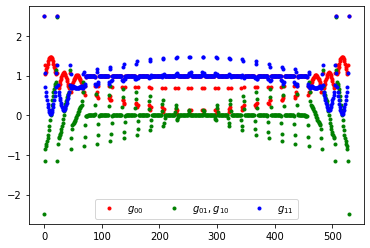

In [ ]:
g00 = [g_reg[i, 0, 0] for i in range(len(g_reg))]
g01 = [g_reg[i, 0, 1] for i in range(len(g_reg))]
g11 = [g_reg[i, 1, 1] for i in range(len(g_reg))]

plt.scatter(range(len(g_reg)), g00, color='r', marker='.', label='$g_{00}$')
plt.scatter(range(len(g_reg)), g01, color='g', marker='.', label='$g_{01}, g_{10}$')
plt.scatter(range(len(g_reg)), g11, color='b', marker='.', label='$g_{11}$')
plt.legend(loc='lower center', ncol=3)
plt.show()

In [ ]:
print("Average metric (over all vertices):\n")
print("{0}".format(np.around(g_reg.mean(0), 2)))

Average metric (over all vertices):

[[0.9 0. ]
 [0.  0.9]]


In [ ]:
M_ran = Space2d(25, 1, bulk=0.9)
M_ran.sprinkle_ran(seed=1)
M_ran.graph_heat_kernel(epsilon=0.5, s=1)

g_ran = M_ran.g(bulk_only=True)

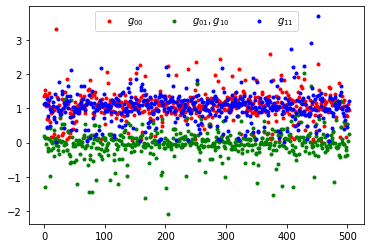

In [ ]:
g00 = [g_ran[i, 0, 0] for i in range(len(g_ran))]
g01 = [g_ran[i, 0, 1] for i in range(len(g_ran))]
g11 = [g_ran[i, 1, 1] for i in range(len(g_ran))]

plt.scatter(range(len(g_ran)), g00, color='r', marker='.', label='$g_{00}$')
plt.scatter(range(len(g_ran)), g01, color='g', marker='.', label='$g_{01}, g_{10}$')
plt.scatter(range(len(g_ran)), g11, color='b', marker='.', label='$g_{11}$')
plt.legend(loc='upper center', ncol=3)
plt.show()

In [ ]:
print("Average metric (over all vertices):\n")
print("{0}".format(np.around(g_ran.mean(0), 2)))

Average metric (over all vertices):

[[ 1.05 -0.02]
 [-0.02  1.04]]


In both cases, the results are correct (i.e., $g = \text{diag}(1, 1)$), well within an errors (which are of order $\epsilon = 0.5$ and $1/\sqrt N \epsilon = 0.08$).

Note that the metric **at a single vertex** does not coincide with the continuous one:

In [ ]:
print(g_ran[0])
print("\n")
print(g_ran[50])
print("\n")
print(g_ran[100])

[[1.36096873 0.18601837]
 [0.18601837 1.13162546]]


[[ 0.92938401 -0.03418581]
 [-0.03418581  0.9138442 ]]


[[1.00796967 0.07690019]
 [0.07690019 1.14672658]]


It is only the average of these fluctuations -- takne over sufficiently many points (here $N = 625$, which corresponds to integrating the metric over a region of size $25 \ell_{\rm Planck}$) -- that reproduces the correct result.

Can interpret this fact by saying that, at the Planck scale, there are **fluctuations in the geometry**?

For completeness, let us check that the result does not change much under a symmetry transformation:

In [ ]:
M_reg_alt = Space2d(25, 1, bulk=0.7)
M_reg_alt.sprinkle_reg()
M_reg_alt.rotat(np.pi/8)
M_reg_alt.graph_heat_kernel(epsilon=0.5, s=1)

g_reg_alt = M_reg_alt.g(bulk_only=True)

In [ ]:
np.around(g_reg_alt.mean(0), 2)

array([[0.91, 0.  ],
       [0.  , 0.91]])

In [ ]:
M_ran_alt = Space2d(25, 1, bulk=0.7)
M_ran_alt.sprinkle_ran(seed=1)
M_ran_alt.rotat(np.pi/4)
M_ran_alt.graph_heat_kernel(epsilon=0.5, s=1)

g_ran_alt = M_ran_alt.g(bulk_only=True)

In [ ]:
np.around(g_ran_alt.mean(0), 2)

array([[ 1.05, -0.01],
       [-0.01,  1.05]])

# 4. Discussion

Concerning the status of symmetries and discretization, we have a way to discretize the space which -- while not strictly **invariant** under the symmetries of the continuum manifold -- seems to resolve the issue of the selectin of a preferred frame: transforming a realization of Poisson distribution with a symmetry produces another realization of Poisson distribution, and since these realizations are random outcomes from the same distribution, we cannot single out one of them. The fundamental reason why this works is because **the Poisson distribution itself is invariant**, since it is based on the spacetime volume of each cell (which is an invariant quantity under the symmetries).

But is this really the end of the story? Should we be satisfied with a single Poisson discretization? And what about the space-time splitting in this case? (Some discussion about this at the end.)

After discussing the discretizations, we saw how -- once a dicretization is given -- it is possible to encode the geometric data (in terms of the metric) on the corresponding graph. In this context, we confirmed that both discretization work (at least in the case of Euclidean 2-dimensional space).

The procedure described -- based on the manifold heat kernel and the graph Laplacian -- allows to associate a **discrete metric** to a set of vertices (discretization of the manifold). While this is great, it is not the end of the story: with this metric we can compute lengths, areas and angles, but we do not have access to geometric quantities which in the continuum involve the metric's derivatives -- chiefly, Riemann's curvature tensor. How to discretize such objects?

Another drawback of this method is that it relies on the heat kernel and the fact that the Laplacian has positive spectrum in Riemannian manifolds. Can we find a generalization to the Lorentzian case? The obvious choice would be to consider the D'Alembertian, as it does allow to reconstruct the Lorentzian metric in the same way as the Laplacian for Riemannian metrics. However, there is a big problem with it: the spectrum of the D'Alembertian is not necessarily positive, and in fact it is unbounded from below. This means that we cannot use its kernel to define a positive distance between vertices, and hence some entries in the adjacency matrix of the associated graphs diverge!

If we can overcome these difficulties (as well as the technical issues involved in considering a large number of vertices), we would have a reasonable interpretation of macroscopic (continuum) spacetime as emerging from a discrete structure. Moreover, the fact that there are infinitely many such discrete strcutres (e.g., two different Poisson discretizations) that correspond to the same classical manifold, is a realization of the generally foggy idea of "classical gravity as the thermodynamical limit of microscopic (quantum) degrees of freedom":

- The "microscopic" adjective refers to the fact that we have single vertices and discrete structures, which one needs to average on in order to obtain a continuum picture. (Compare with microscopic description of a gas.)

- The "quantum" enters if we construct a Hilbert space spanned by all graphs (like it is done for example in LQG): we can then construct states which are linear combinations of different discrete geometries.

This structure neatly realizes the proposal presented by Alejandro Perez in the last ILQGS talk, of how to resolve the information paradox by "storing" the information in the microscopic "imperfections" of spacetime.

Indeed, we can imagine to separate the geometric degrees of freedom in macroscopic ones (e.g., the mean value of the metric on a block of spacetime consisting of several Planck-sized cells) and microscopic ones (e.g., the deviation from such mean value at every vertex). Then, Schwarzschild classical spacetime is not described by a single quantum state, but rather there exist infinitely many states $|\psi_i\rangle$ (each based on a different Poisson discretization, but all sharing the same "macroscopic part) that are macroscopically interpreted as Schwarzschild:

$$
|\psi_i\rangle = |\phi\rangle \otimes |\varphi_i\rangle
$$

If we take the initial state to be a linear combination of them, we can define the density matrix

$$
\rho(t_0) = |\Psi\rangle \langle\Psi|, \ \ \ \ \ \text{where} \ \ |\Psi\rangle = \left(|\phi\rangle \otimes \sum_{i} a_i |\varphi_i\rangle\right) \otimes \left(\sum_{\alpha} b_\alpha |\chi_\alpha\rangle\right)
$$

where $\{|\chi_\alpha\rangle\}$ is a basis for the Hilbert space of matter (e.g., a scalar field which would later give rise to Hawking radiation). Since each $|\varphi_i\rangle$ is slightly different from the others, it is reasonable to expect that the interaction with matter will produce entanglement, so that the final density matrix is

$$
\rho(t_1) = |\Psi'\rangle \langle\Psi'|, \ \ \ \ \ \text{where} \ \ |\Psi'\rangle = \sum_{A, i, \alpha} c_{A, i, \alpha} |\phi_A\rangle |\varphi_i\rangle |\chi_\alpha\rangle
$$

where $\{|\phi_A\rangle\}$ spans Hilbert space of macroscopic geometric degrees of freedom. We can then take the trace over the microscopic geometric dof's (keeping the macroscopic ones), thus obtaining a mixed state for matter on continuum spacetime:

$$
\rho_{\rm macro}(t_1) := \text{Tr}_{\rm micro}[\rho(t_1)] = \sum_{A, B, \alpha, \beta} d_{A,B,\alpha,\beta} |\phi_A\rangle \langle \phi_B| \otimes |\chi_\alpha\rangle \langle\chi_\beta|, \ \ \ \ \ \text{with} \ \ d_{A,B,\alpha,\beta} := \sum_i c_{A, i, \alpha} \overline{c_{B, i, \beta}}
$$

If this state can be thought of as a quantum field on a classical geometry $|\phi'\rangle$, it must approximately be of the form

$$
\rho_{\rm macro}(t_1) \approx |\phi'\rangle \langle \phi'| \otimes \left(\sum_{\alpha, \beta} D_{\alpha,\beta} |\chi_\alpha\rangle \langle\chi_\beta|\right)
$$

The interpretation is now the following: $|\phi'\rangle$ describes the macroscopic geometry (after black hole evaporation/resolution), for example Minkowski; the rest is a mixed state of matter (e.g., a thermal state for Hawking radiation). Still, there was no violation of unitarity: the missing information is stored in the impenetrable Planckian structure of the quantum geometry.

# 5. Extra: Spatial Slices

Let us forget about the metric for now, and let us go back to the issue of regular VS Poisson discretizations.

We saw that the regular discretization does not follow a Poisson distribution, but is that really so bad? The metric is recovered well without any problems, so in what sense does the regular discretization "allows to single out a frame"? Since a frame is ultimately a space-time splitting, one way to try to answer this question is to consider how **spatial slices** behave under symmetry transformations. In what follows, we will thus consider a $1+1$ decomposition.

Given that the slices are now 1-dimensional, there is not so much we can discuss about them (e.g., remaining symmetries). However, one relevant question we can ask is: does the number of vertices in a spatial slice change if we perform a symmetry transformation?

To address this question, we must first define what we mean by "spatial slice" in the discretization. Taking an experimental point of view -- where our resolution is limited -- we define a spatial slice as a region of space which is 1-cell thick in the $x_2$ direction (the vertical axis), and otherwise extends througout the whole $x_1$ direction (the horizontal axis).

Let us start with the regular discretization.

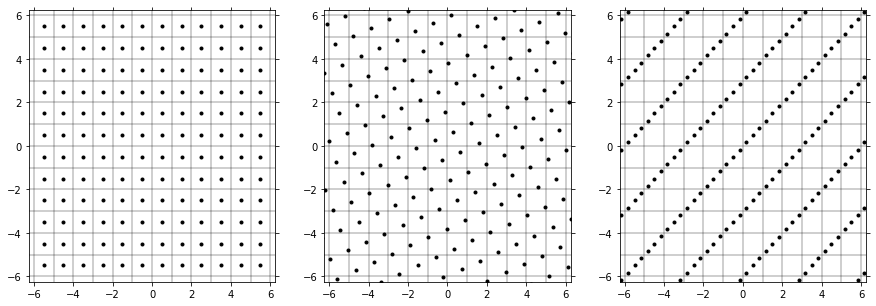

In [ ]:
Mreg1_alt = Space2d(50, 1, bulk=0.25)
Mreg2_alt = Space2d(50, 1, bulk=0.25)
Mreg3_alt = Space2d(50, 1, bulk=0.25)

Mreg1_alt.sprinkle_reg()
Mreg2_alt.sprinkle_reg()
Mreg3_alt.sprinkle_reg()

Mreg2_alt.rotat(np.pi/8)
Mreg3_alt.boost(0.8)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
Mreg1_alt.plot(ax=axes[0], cells=True, graph=False, color='k')
Mreg2_alt.plot(ax=axes[1], cells=True, graph=False, color='k')
Mreg3_alt.plot(ax=axes[2], cells=True, graph=False, color='k')

In [ ]:
def spatial_slices(space, bulk_only=False):
# return an ordered list of slices (from "past" to "future"): every entry (slice) is itself a list, containing all cells that belong to that slice
  slice_thickness = space.l
  space_thickness = space.size
  n_slices = space.M
  S = np.linspace(-space_thickness/2, space_thickness/2 - 1, n_slices)
  slice_list = [[] for i in range(n_slices)]
  for cell in space.cells:
    t = cell.coords[1]
    for i in range(len(S)):
      if S[i] <= t < S[i] + slice_thickness:
        slice_list[i].append(cell)
        break
  if bulk_only: # delete the boundary slices
    b = (1 - space.bulk)/2
    cut = int(np.ceil(len(slice_list) * b))
    slice_list = slice_list[cut:-cut]
  return slice_list

def spatial_C(space, bulk_only=False):
# return a rank-2 array: the ith row corresponds to the ith slice (ordered from "past" to "future")
# the jth element of that row is the number of (bulk) vertices in the jth cell of that slice
  ss = spatial_slices(space, bulk_only)
  CC = []
  for spatial_slice in ss:
    C = []
    for cell in spatial_slice:
      count = 0
      for vert in space.verts_b:
        if cell.contains(vert):
          count = count + 1
      C.append(count)
    CC.append(C)
  return np.array(CC)

In [ ]:
CC_reg1_alt = spatial_C(Mreg1_alt, bulk_only=True)
CC_reg2_alt = spatial_C(Mreg2_alt, bulk_only=True)
CC_reg3_alt = spatial_C(Mreg3_alt, bulk_only=True)

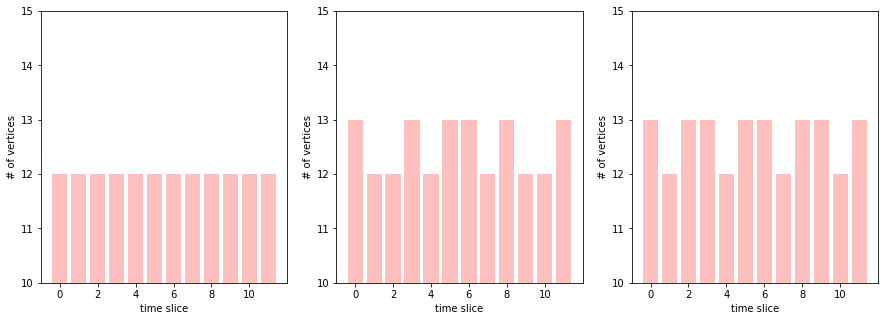

In [ ]:
T1 = np.array(range(len(CC_reg1_alt)))
T2 = np.array(range(len(CC_reg2_alt)))
T3 = np.array(range(len(CC_reg3_alt)))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].bar(T1, CC_reg1_alt.sum(1), color='r', alpha=0.25)
axes[1].bar(T2, CC_reg2_alt.sum(1), color='r', alpha=0.25)
axes[2].bar(T3, CC_reg3_alt.sum(1), color='r', alpha=0.25)

axes[0].set_xlabel("time slice")
axes[0].set_ylabel("# of vertices")
axes[0].set_ylim(10, 15)
axes[1].set_xlabel("time slice")
axes[1].set_ylabel("# of vertices")
axes[1].set_ylim(10, 15)
axes[2].set_xlabel("time slice")
axes[2].set_ylabel("# of vertices")
axes[2].set_ylim(10, 15)

plt.show()

In [ ]:
Mreg_dyn = Space2d(50, 1, bulk=0.25)
Mreg_dyn.sprinkle_reg()

def update(v):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  Mreg_dyn.boost(v)
  CC_reg_dyn = spatial_C(Mreg_dyn, bulk_only=True)
  Mreg_dyn.boost(-v)
  Treg_dyn = np.array(range(len(CC_reg_dyn)))
  plt.bar(Treg_dyn, CC_reg_dyn.sum(1), color='r', alpha=0.25)
  plt.xlabel("time slice")
  plt.ylabel("# of vertices")
  plt.ylim(10, 16)

widgets.interact(update, v=(-0.9, 0.9, 0.01));

interactive(children=(FloatSlider(value=0.0, description='v', max=0.9, min=-0.9, step=0.01), Output()), _dom_c…

These pictures clarify what it means to have a special frame: it is the frame wrt which all slices have the exact same number of vertices, that is, in some sense, the same spatial volume (although to make this statement more rigorous we would have to study the discrete spatial metric induced by $\tilde g_{\mu\nu}$ on each slice).

Let us take a look at the Poisson discretization.

In [ ]:
Mran1_alt = Space2d(50, 1, bulk=0.25)
Mran2_alt = Space2d(50, 1, bulk=0.25)
Mran3_alt = Space2d(50, 1, bulk=0.25)

Mran1_alt.sprinkle_ran()
Mran2_alt.sprinkle_ran()
Mran3_alt.sprinkle_ran()

Mran2_alt.rotat(np.pi/8)
Mran3_alt.boost(0.8)

In [ ]:
CC_ran1_alt = spatial_C(Mran1_alt, bulk_only=True)
CC_ran2_alt = spatial_C(Mran2_alt, bulk_only=True)
CC_ran3_alt = spatial_C(Mran3_alt, bulk_only=True)

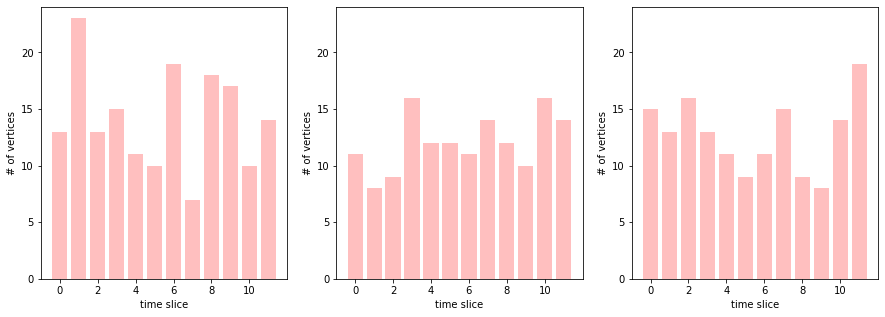

In [ ]:
T1 = np.array(range(len(CC_ran1_alt)))
T2 = np.array(range(len(CC_ran2_alt)))
T3 = np.array(range(len(CC_ran3_alt)))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].bar(T1, CC_ran1_alt.sum(1), color='r', alpha=0.25)
axes[1].bar(T2, CC_ran2_alt.sum(1), color='r', alpha=0.25)
axes[2].bar(T3, CC_ran3_alt.sum(1), color='r', alpha=0.25)

axes[0].set_xlabel("time slice")
axes[0].set_ylabel("# of vertices")
axes[0].set_ylim(0, 24)
axes[1].set_xlabel("time slice")
axes[1].set_ylabel("# of vertices")
axes[1].set_ylim(0, 24)
axes[2].set_xlabel("time slice")
axes[2].set_ylabel("# of vertices")
axes[2].set_ylim(0, 24)

plt.show()

In [ ]:
Mran_dyn = Space2d(50, 1, bulk=0.25)
Mran_dyn.sprinkle_ran()

def update(v):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  Mran_dyn.boost(v)
  CC_ran_dyn = spatial_C(Mran_dyn, bulk_only=True)
  Mran_dyn.boost(-v)
  Tran_dyn = np.array(range(len(CC_ran_dyn)))
  plt.bar(Tran_dyn, CC_ran_dyn.sum(1), color='r', alpha=0.25)
  plt.xlabel("time slice")
  plt.ylabel("# of vertices")
  plt.ylim(0, 30)

widgets.interact(update, v=(-0.9, 0.9, 0.01));

interactive(children=(FloatSlider(value=0.0, description='v', max=0.9, min=-0.9, step=0.01), Output()), _dom_c…

It is not clear how to interpret this: on the one hand, we have no "special" frame (in the sense described above); on the other hand, the variance in the number of vertices per slice is much larger than in the regular case -- do these "fluctuations" of the spatial volume in time constitute a problem for the underlying 3-geometry?